# HOMEWORK 2 OF ALGORITHMICS METHOD OF DATA MINING

This homework is the made by the collective effort of the following people:\
Can Lin, 1994375\
Amirhosein Dalvand 2056639\
Taramanni Giorgio 1961217\
add your name and matricola \
XY

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [86]:
# Read the CSV
df = pd.read_csv('steam_reviews.csv', nrows=2000000, on_bad_lines='skip', index_col=0)

# Convert columns from Unix time (seconds) to datetime
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s', errors='coerce')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit='s', errors='coerce')
df['author.last_played'] = pd.to_datetime(df['author.last_played'], unit='s', errors='coerce')

### <strong>[RQ1] Before diving deep into the dataset provided, it's crucial to understand its structure and main features. Data scientists usually take the first step of performing an Exploratory Data Analysis (EDA). What can you say about our dataset? Please perform an EDA and summarize the dataset's key characteristics using visualizations and tabular summaries.   </strong>

In [ ]:
df.head(5)

In [5]:
df.shape

(2000000, 22)

In [14]:
df.columns

Index(['app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

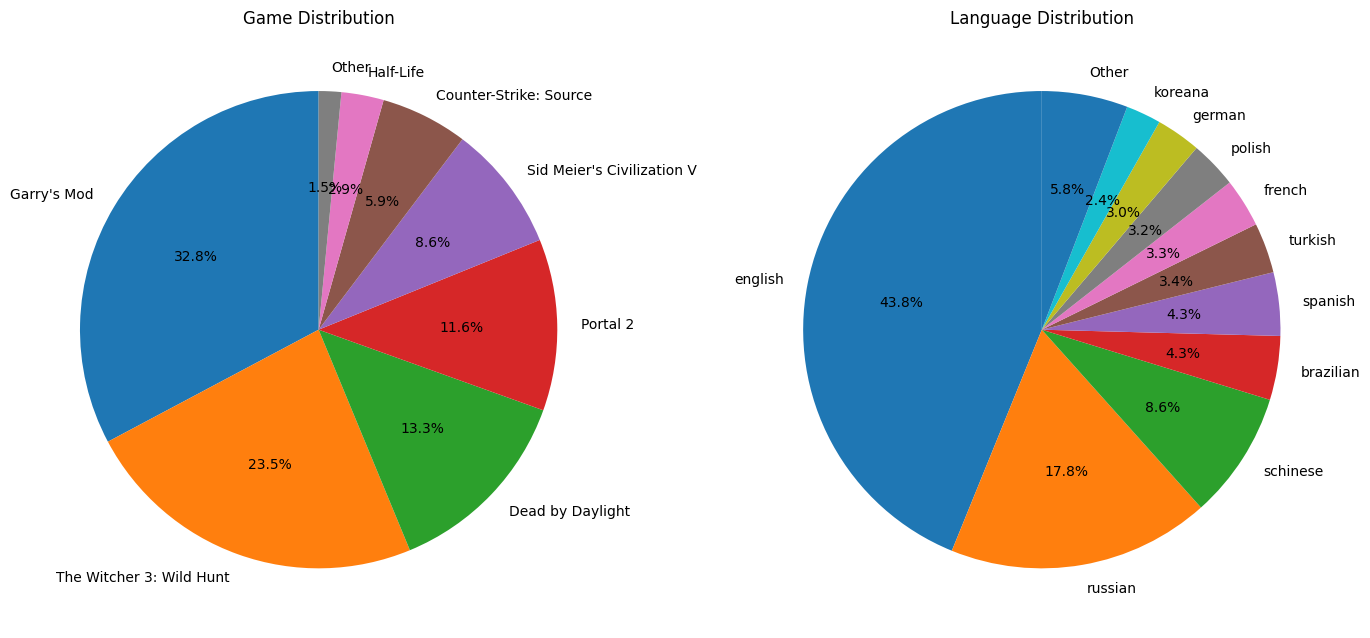

In [6]:
game_counts = df['app_name'].value_counts(normalize=True) * 100
language_counts = df['language'].value_counts(normalize=True) * 100

# Function to group small categories into 'Other'
def group_small_categories(counts, threshold=2):
    small_categories = counts[counts < threshold].sum()
    counts = counts[counts >= threshold]
    counts['Other'] = small_categories
    return counts

# Group games and languages with less than 5% into 'Other'
game_counts_grouped = group_small_categories(game_counts)
language_counts_grouped = group_small_categories(language_counts)

# Create subplots for both Game and Language pie charts
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for Games
ax[0].pie(game_counts_grouped, labels=game_counts_grouped.index, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Game Distribution')

# Pie chart for Languages
ax[1].pie(language_counts_grouped, labels=language_counts_grouped.index, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Language Distribution')

# Show the charts
plt.tight_layout()
plt.show()

### <strong>RQ3 Understanding when users are most active in submitting reviews can help identify peak engagement periods

<strong> Plot the number of reviews submitted each month and describe any trends.

In [9]:
df['month'] = df['timestamp_created'].dt.strftime('%B')
groupbyMonth = df.groupby('month')

monthly_count = groupbyMonth.size()

In [13]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_counts_sorted = monthly_count.reindex(month_order)

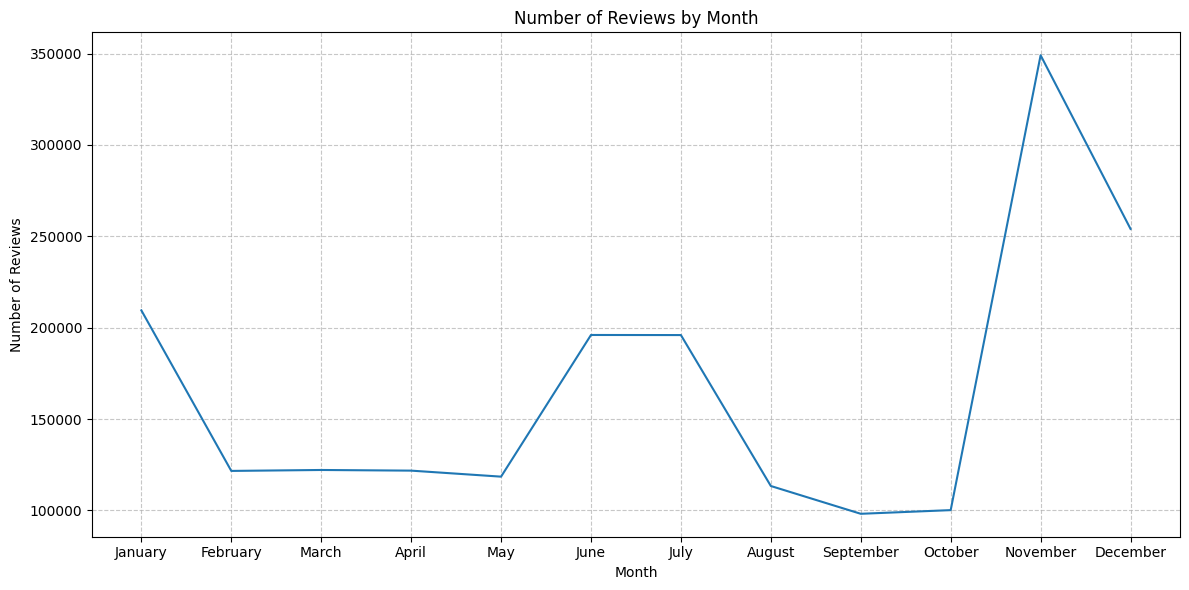

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts_sorted.index, monthly_counts_sorted.values)
plt.title('Number of Reviews by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

 <strong> Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.<br> </strong>
 We can see that during the summer there is a small spike in game reviews which coincide with the summer break for students,<br> while there is a big spike in November which might correspond to the month when usually major games are released

<strong> Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity. </strong> <br>
To answer but its the same as before


<strong> What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis. </strong>

In [38]:
df['minute_hour'] = df['timestamp_created'].dt.strftime('%H:%M')

# Count reviews by half-hour
minute_hour_counts = df['minute_hour'].value_counts().sort_index()


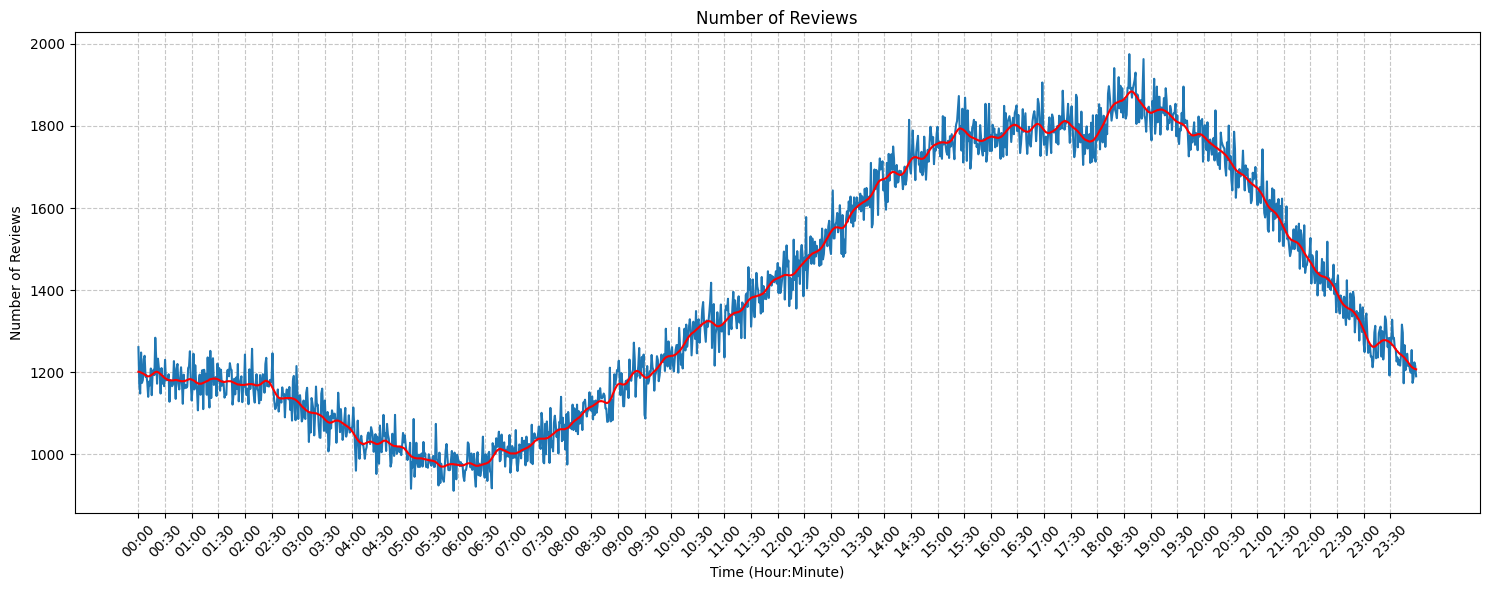

In [47]:

# Filter the index to show only half-hour intervals ('00', '30' minutes)
half_hour_indices = [i for i, time in enumerate(minute_hour_counts.index) if time[-2:] in ['00', '30']]
smoothed_values = gaussian_filter1d(minute_hour_counts.values, sigma=5)


plt.figure(figsize=(15, 6))
plt.plot(minute_hour_counts.index, minute_hour_counts.values, marker='', linestyle='-')
plt.plot(minute_hour_counts.index, smoothed_values, color='red', label='Smoothed line') #a smoothed line using a Gaussian filter
plt.title('Number of Reviews')
plt.xlabel('Time (Hour:Minute)')
plt.ylabel('Number of Reviews')

# Display only every half hour in x-ticks
plt.xticks(ticks=half_hour_indices, labels=np.array(minute_hour_counts.index)[half_hour_indices], rotation=45)

# Remove MaxNLocator and MultipleLocator since we are manually controlling ticks
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


It looks like that most people write a review in the afternoon/evening with a spike around 15:00-19:00

<strong> Create a function that accepts a list of time intervals and plots the number of reviews for each interval. </strong>

In [71]:
def plotTimeInterval(df, start, end):
    # Create a new column for formatted time
    df['minute_hour'] = df['timestamp_created'].dt.strftime('%H:%M')
    
    # Count occurrences and filter by time range
    minute_hour_counts = df['minute_hour'].value_counts().sort_index()
    minute_hour_counts = minute_hour_counts[(minute_hour_counts.index >= start) & (minute_hour_counts.index <= end)]

    # Apply Gaussian smoothing
    smoothed_values = gaussian_filter1d(minute_hour_counts.values, sigma=3)

    plt.figure(figsize=(15, 6))
    # Add labels to the plots
    plt.plot(minute_hour_counts.index, minute_hour_counts.values, marker='', linestyle='-', label='Original Data')
    plt.plot(minute_hour_counts.index, smoothed_values, color='red', label='Smoothed Line')

    plt.title('Number of Reviews')
    plt.xlabel('Time (Hour:Minute)')
    plt.ylabel('Number of Reviews')

    # Create x-ticks for every 5 minutes within the start and end range
    time_labels = pd.date_range(start=start, end=end, freq='5min').strftime('%H:%M')

    # Determine tick positions for 5-minute intervals
    tick_positions = np.arange(0, len(minute_hour_counts), 5)  # Every 5th index

    # Set the x-ticks and labels
    plt.xticks(ticks=tick_positions, labels=time_labels[:len(tick_positions)], rotation=45)

    plt.legend()  # Ensure the legend is shown correctly
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

<strong>Use the function to plot the number of reviews for the following time intervals:</strong>

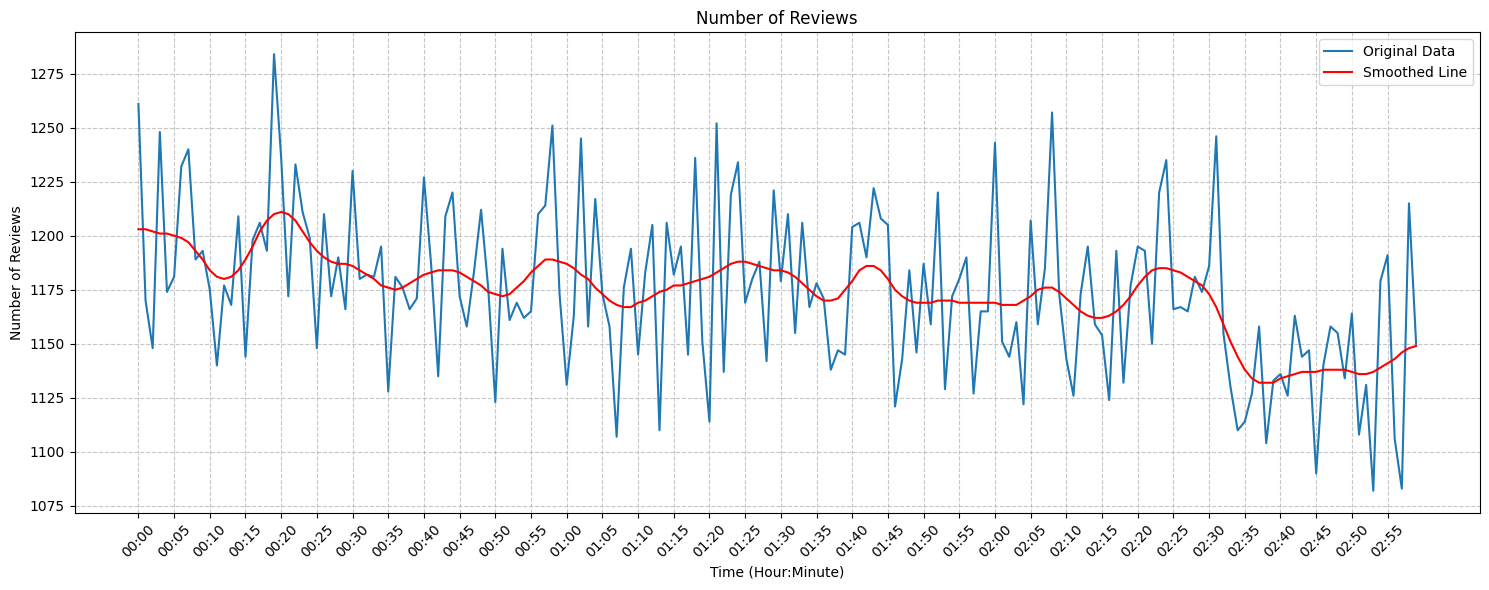

In [72]:
plotTimeInterval(df,'00:00','02:59')

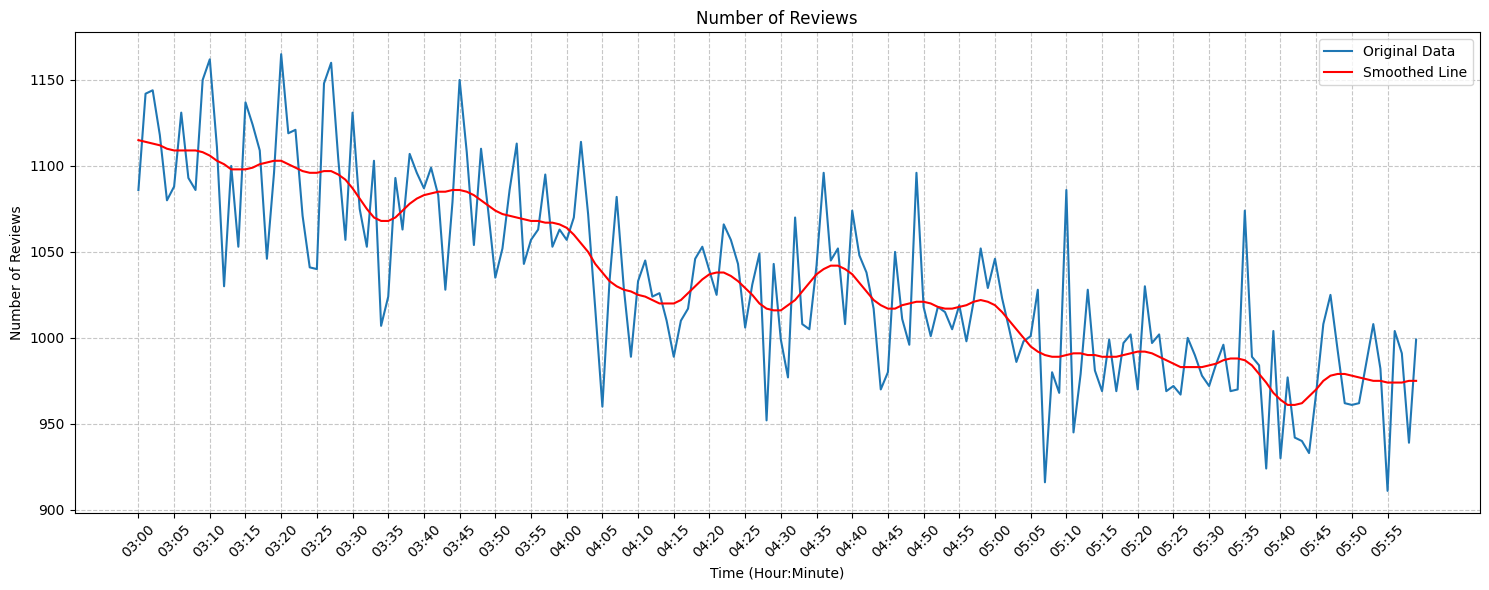

In [73]:
plotTimeInterval(df,'03:00','05:59')

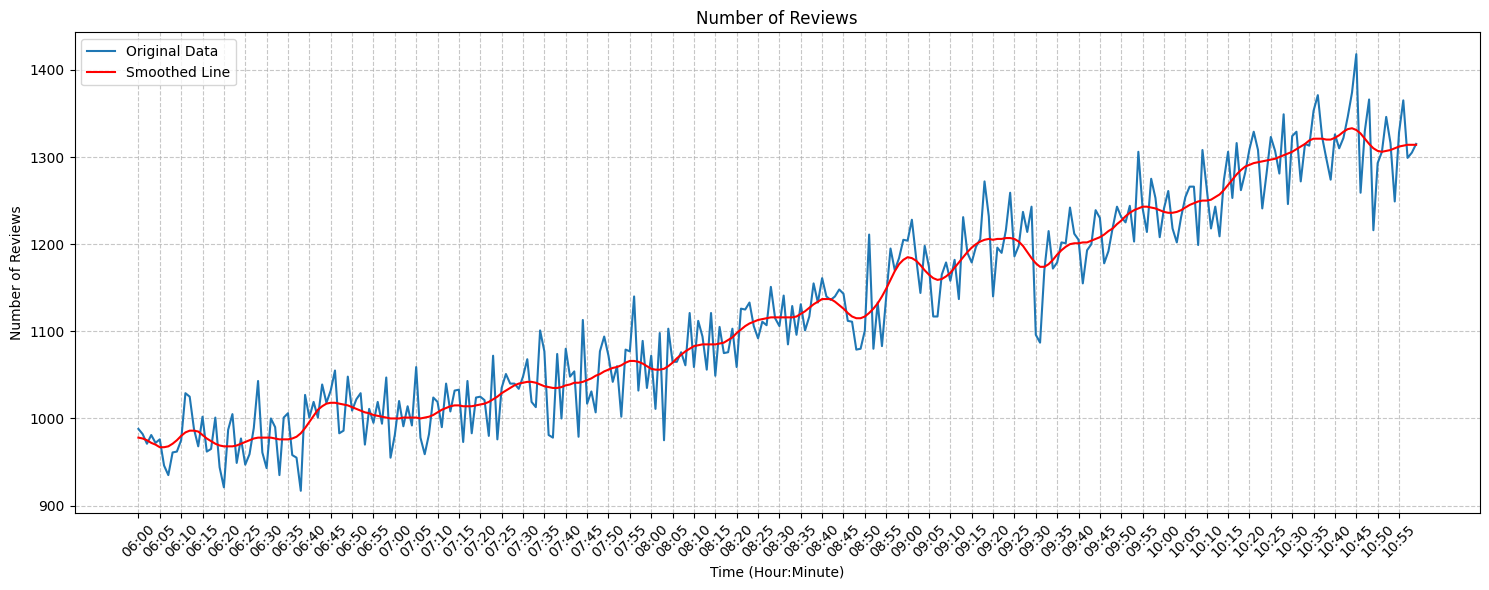

In [74]:
plotTimeInterval(df,'06:00','10:59')

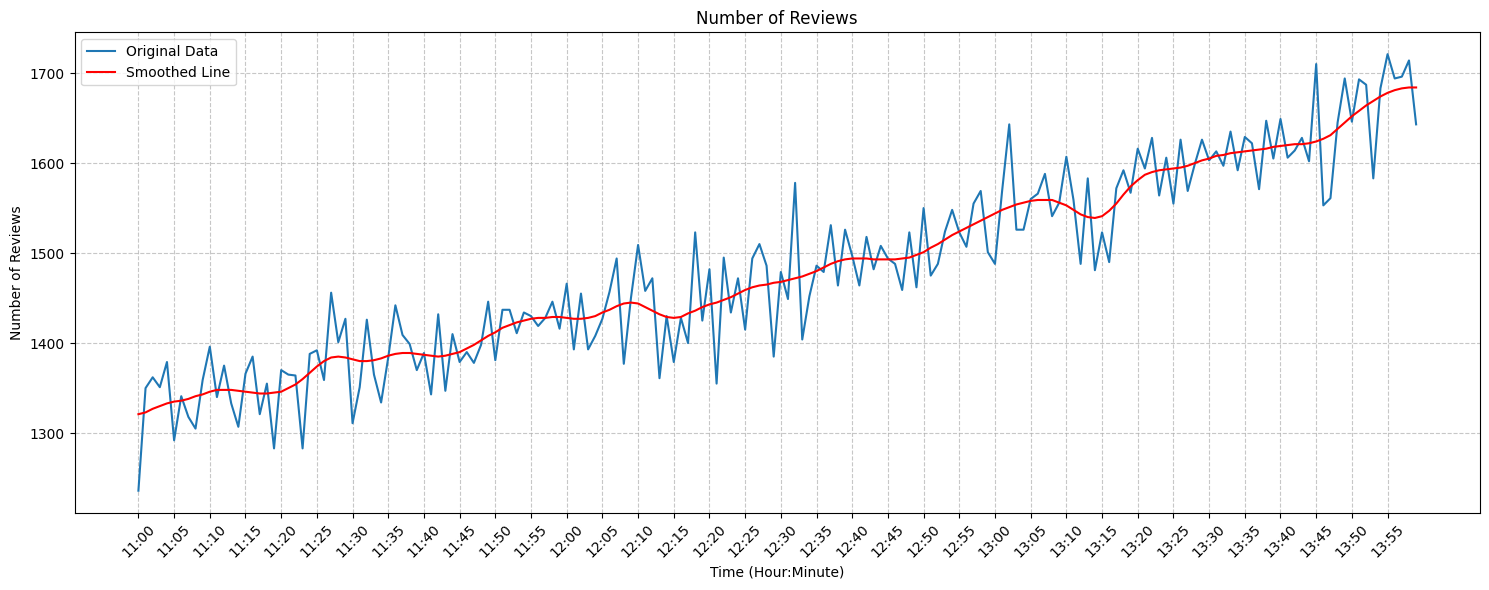

In [75]:
plotTimeInterval(df,'11:00','13:59')

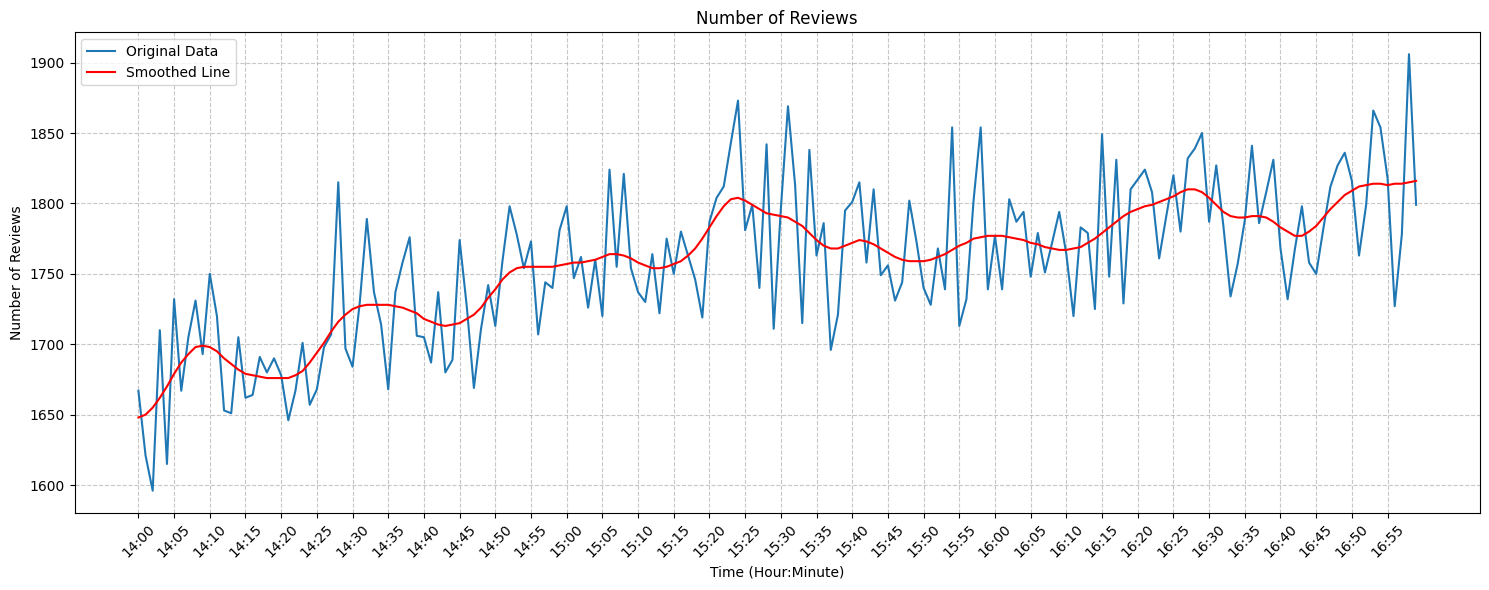

In [76]:
plotTimeInterval(df,'14:00','16:59')

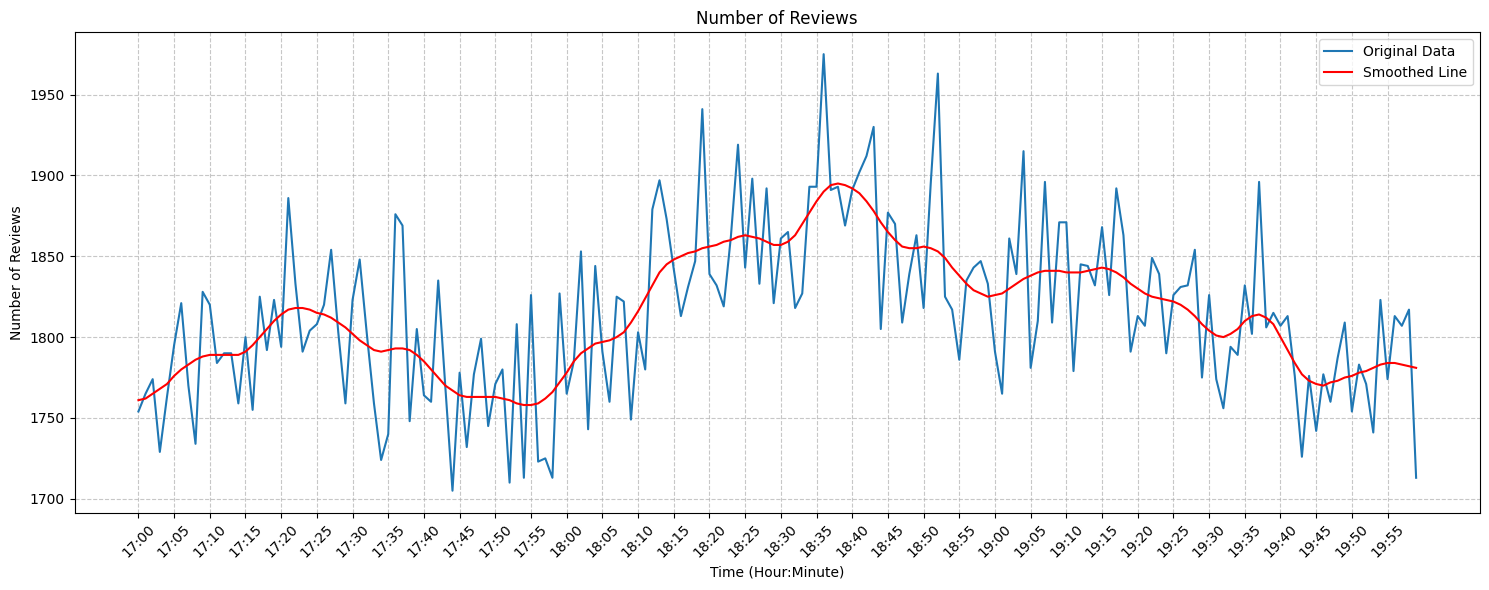

In [77]:
plotTimeInterval(df,'17:00','19:59')

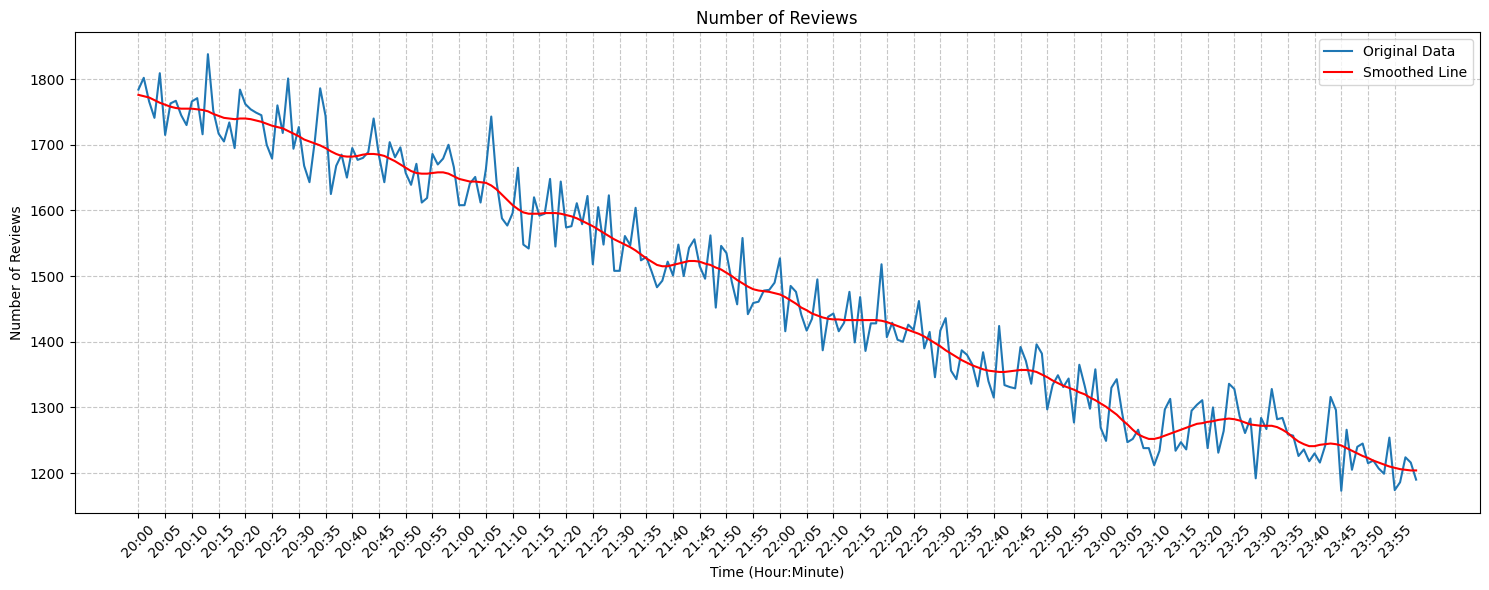

In [78]:
plotTimeInterval(df,'20:00','23:59')

### <strong>[RQ6] Let's investigate the behavior of specific groups, specifically focusing on English and Spanish reviewers</strong>

First of all, let's filter the dataframe by english and spanish first

In [89]:
english = df[df['language'] == 'english']
spanish = df[df['language'] == 'spanish']

<strong> Which group is more likely to edit or update their review after submitting it? “English or Spanish!”? </strong>

In [91]:
english_change = english[english['timestamp_created'] != english['timestamp_updated']]
spanish_change = spanish[spanish['timestamp_created'] != spanish['timestamp_updated']]

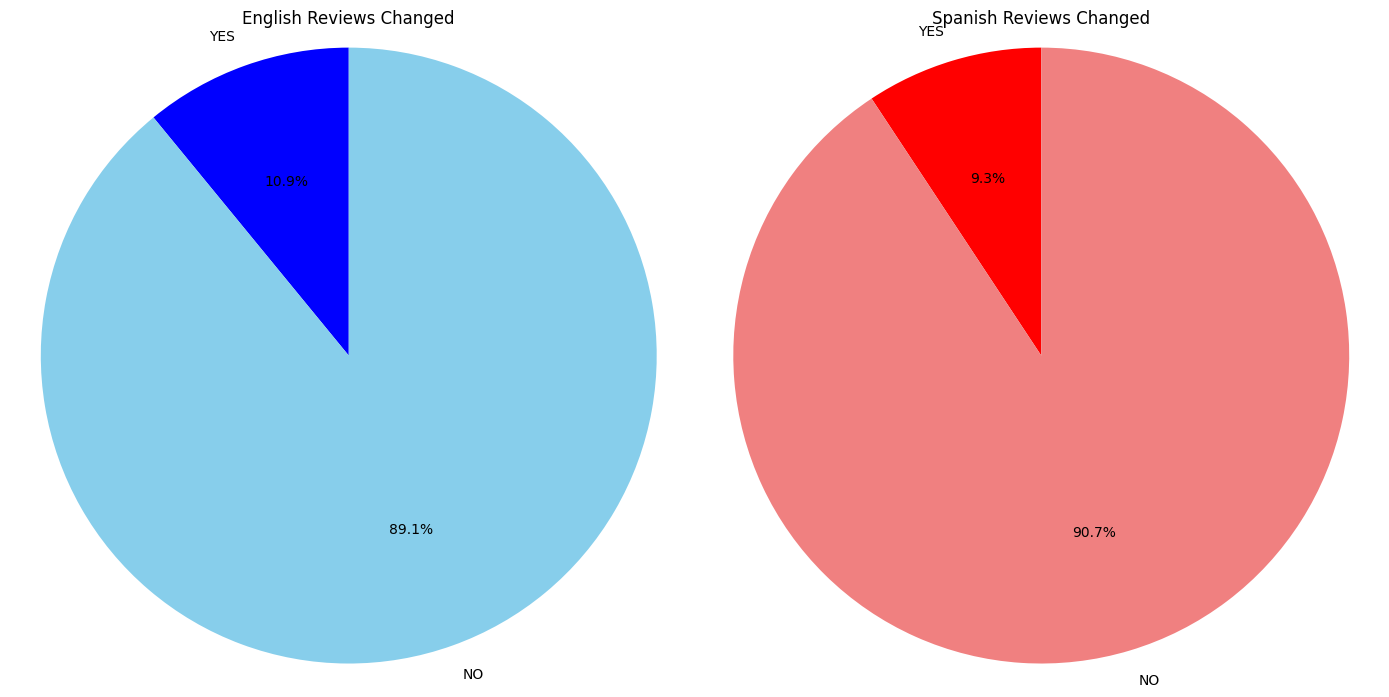

In [94]:

english_count = len(english)
spanish_count = len(spanish)

changed_english_proportion = len(english_change) / english_count
changed_spanish_proportion = len(spanish_change) / spanish_count

# Step 4: Create the pie charts
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# English Reviews Pie Chart
axs[0].pie([changed_english_proportion, 1 - changed_english_proportion], 
            labels=['YES', 'NO'], 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=['blue','skyblue'])
axs[0].set_title('English Reviews Changed')

# Spanish Reviews Pie Chart
axs[1].pie([changed_spanish_proportion, 1 - changed_spanish_proportion], 
            labels=['YES', 'NO'], 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=['red','lightcoral'])
axs[1].set_title('Spanish Reviews Changed')

# Equal aspect ratio ensures that pie charts are circles
for ax in axs:
    ax.axis('equal')

plt.tight_layout()
plt.show()

It seems that English reviews are more likely to be changed than Spanish reviews.

<strong> Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated? </strong>

In [103]:
english_mean_games = english['author.num_games_owned'].mean()
spanish_mean_games = spanish['author.num_games_owned'].mean()

english_mean_reviews = english['author.num_reviews'].mean()
spanish_mean_reviews = spanish['author.num_reviews'].mean()

english_mean_reviews_per_game = english_mean_reviews / english_mean_games * 100
spanish_mean_reviews_per_game = spanish_mean_reviews / spanish_mean_games * 100

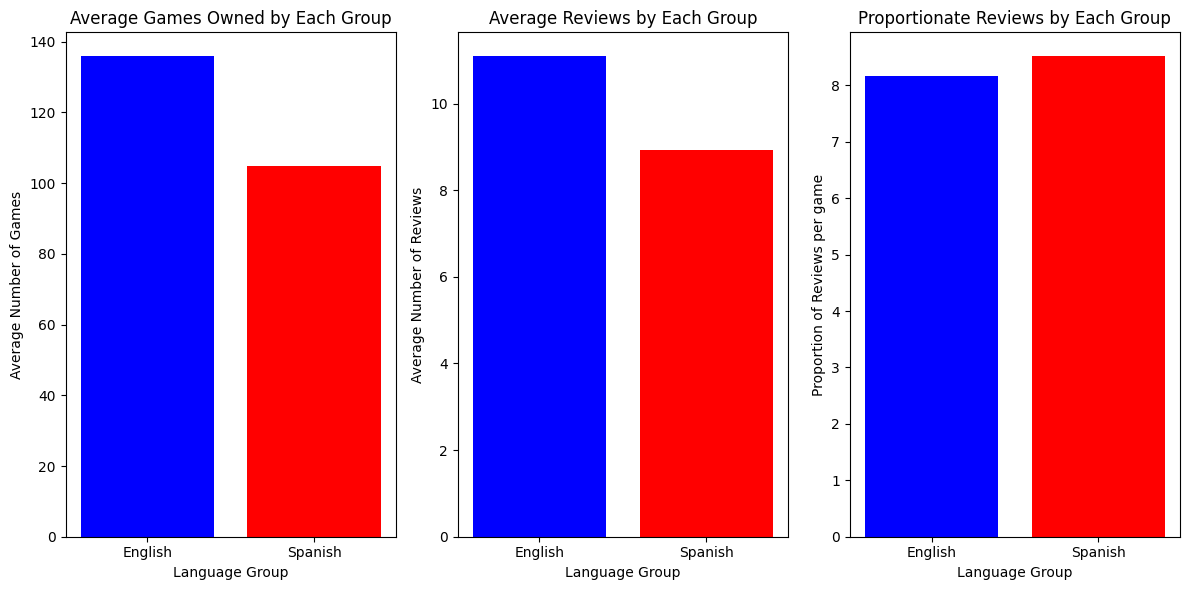

In [104]:
fig , axs = plt.subplots(1,3, figsize = (12,6))

# First bar plot for average games Owned
axs[0].bar(['English', 'Spanish'], [english_mean_games, spanish_mean_games], color=['blue', 'red'])
axs[0].set_title('Average Games Owned by Each Group')
axs[0].set_xlabel('Language Group')
axs[0].set_ylabel('Average Number of Games')

# Second bar plot for average reviews
axs[1].bar(['English', 'Spanish'], [english_mean_reviews, spanish_mean_reviews], color=['blue', 'red'])
axs[1].set_title('Average Reviews by Each Group')
axs[1].set_xlabel('Language Group')
axs[1].set_ylabel('Average Number of Reviews')

# Third bar plot for proportion of reviews per game
axs[2].bar(['English', 'Spanish'], [english_mean_reviews_per_game, spanish_mean_reviews_per_game], color=['blue', 'red'])
axs[2].set_title('Proportionate Reviews by Each Group')
axs[2].set_xlabel('Language Group')
axs[2].set_ylabel('Proportion of Reviews per game')

# Show the plots
plt.tight_layout()  # Optional: adjusts subplot parameters for better layout
plt.show()

It is evident that game reviews are relatively sparse, with fewer than 10% of games receiving reviews. Interestingly, while English users have higher average numbers for both games owned and reviews written, Spanish users exhibit a higher ratio of reviews per game. This suggests that, despite a lower overall volume of reviews, Spanish users engage more actively in providing feedback relative to their game ownership.